In [11]:
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
pca = PCA(n_components=8)

mnist = fetch_openml('mnist_784')
X_orig, y_orig = mnist["data"], mnist["target"]

X_orig = mms.fit_transform(np.array(X_orig).astype(np.float32))
y_orig = np.array(y_orig).astype(np.uint8)
target_digit1 = 3
target_digit2 = 8

target_digit1_xdata = X_orig[y_orig == target_digit1]
target_digit2_xdata = X_orig[y_orig == target_digit2]
target_digit1_ydata = y_orig[y_orig == target_digit1]
target_digit2_ydata = y_orig[y_orig == target_digit2]
X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)
y = np.where(y == target_digit1, 0, 1)
X = pca.fit_transform(X)
X = mms.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

pca.fit(X_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(8379, 8) (2793, 8) (2794, 8)
(8379,) (2793,) (2794,)


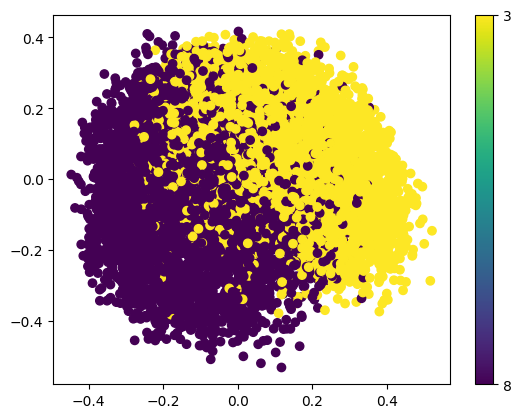

In [12]:
pca2 = PCA(n_components=2)
plotx = pca.fit_transform(X_train)

formatter = plt.FuncFormatter(lambda i, *args: np.where(y_train[i] == 1, target_digit2, target_digit1))
plt.scatter(plotx[:, 0], plotx[:, 1], c=y_train)
plt.colorbar(ticks=[0, 1], format=formatter)
# plt.xlabel(iris.feature_names[x_index])
# plt.ylabel(iris.feature_names[y_index])
plt.show()

In [13]:
dim = len(X[0])
w = torch.autograd.Variable(torch.rand(dim), requires_grad=True)
b = torch.autograd.Variable(torch.rand(1),   requires_grad=True)

step_size = 1e-3
num_epochs = 5000
minibatch_size = 20

for epoch in range(num_epochs):
    inds = [i for i in range(len(X_train))]
    shuffle(inds)
    for i in range(len(inds)):
        L = max(0, 1 - y_train[inds[i]] * (torch.dot(w, torch.Tensor(X_train[inds[i]])) - b))**2
        if L != 0: # if the loss is zero, Pytorch leaves the variables as a float 0.0, so we can't call backward() on it
            L.backward()
            w.data -= step_size * w.grad.data # step
            b.data -= step_size * b.grad.data # step
            w.grad.data.zero_()
            b.grad.data.zero_()

print('plane equation:  w=', w.detach().numpy(), 'b =', b.detach().numpy()[0])

def accuracy(X, y):
    correct = 0
    for i in range(len(y)):
        y_predicted = int(np.sign((torch.dot(w, torch.Tensor(X[i])) - b).detach().numpy()[0]))
        if y_predicted == y[i]: correct += 1
    return float(correct)/len(y)

print('train accuracy', accuracy(X_train, y_train))
print('test accuracy', accuracy(X_test, y_test))

KeyboardInterrupt: 

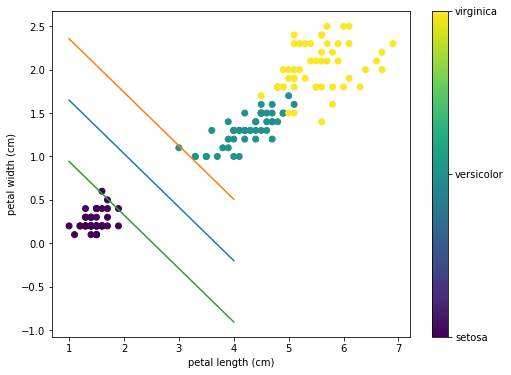

In [25]:
def line_func(x, offset):
    return   -1 * (offset - b.detach().numpy()[0] + w.detach().numpy()[0] * x ) / w.detach().numpy()[1]

x = np.array(range(1, 5))
ym = line_func(x,  0)
yp = line_func(x,  1)
yn = line_func(x, -1)

x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)